In [1]:
import pandas as pd

data = pd.read_csv('demanda.csv')

data.head()

,fecha,producto,demanda
0,2018-01-01,CERVEZA_LATA_350ML,182.0
1,2018-01-02,CERVEZA_LATA_350ML,176.0
2,2018-01-03,CERVEZA_LATA_350ML,181.0
3,2018-01-04,CERVEZA_LATA_350ML,183.0
4,2018-01-05,CERVEZA_LATA_350ML,181.0


In [2]:
data.tail()

,fecha,producto,demanda
1821,2022-12-27,CERVEZA_LATA_350ML,198.0
1822,2022-12-28,CERVEZA_LATA_350ML,200.0
1823,2022-12-29,CERVEZA_LATA_350ML,209.0
1824,2022-12-30,CERVEZA_LATA_350ML,200.0
1825,2022-12-31,CERVEZA_LATA_350ML,209.0


In [3]:
data.describe()

,demanda
count,1826.000000
mean,192.845016
std,12.064374
min,159.000000
25%,185.000000
50%,193.000000
75%,202.000000
max,232.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     1826 non-null   object 
 1   producto  1826 non-null   object 
 2   demanda   1826 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.9+ KB


In [5]:
data.isnull().sum()

fecha       0
producto    0
demanda     0
dtype: int64

In [6]:
# Convertir columna fecha a datetime

data['fecha'] = pd.to_datetime(data['fecha'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   fecha     1826 non-null   datetime64[ns]
 1   producto  1826 non-null   object        
 2   demanda   1826 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.9+ KB


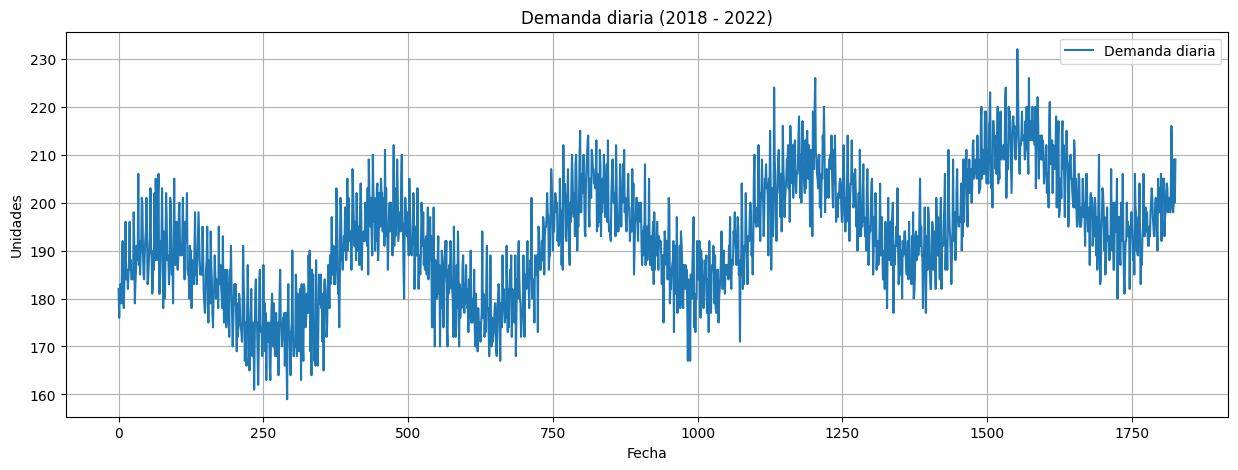

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(data['demanda'], label='Demanda diaria')
plt.title("Demanda diaria (2018 - 2022)")
plt.xlabel("Fecha")
plt.ylabel("Unidades")
plt.legend()
plt.grid(True)
plt.show()


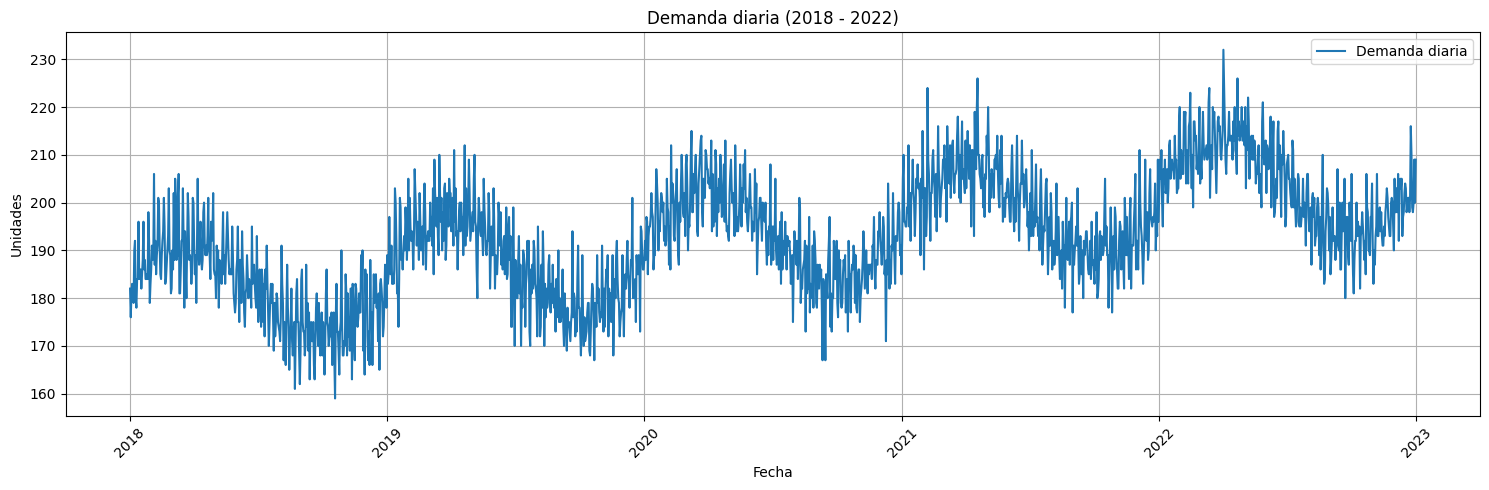

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(data['fecha'], data['demanda'], label='Demanda diaria')  # Eje x explícito
plt.title("Demanda diaria (2018 - 2022)")
plt.xlabel("Fecha")
plt.ylabel("Unidades")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rota etiquetas de fecha
plt.tight_layout()
plt.show()


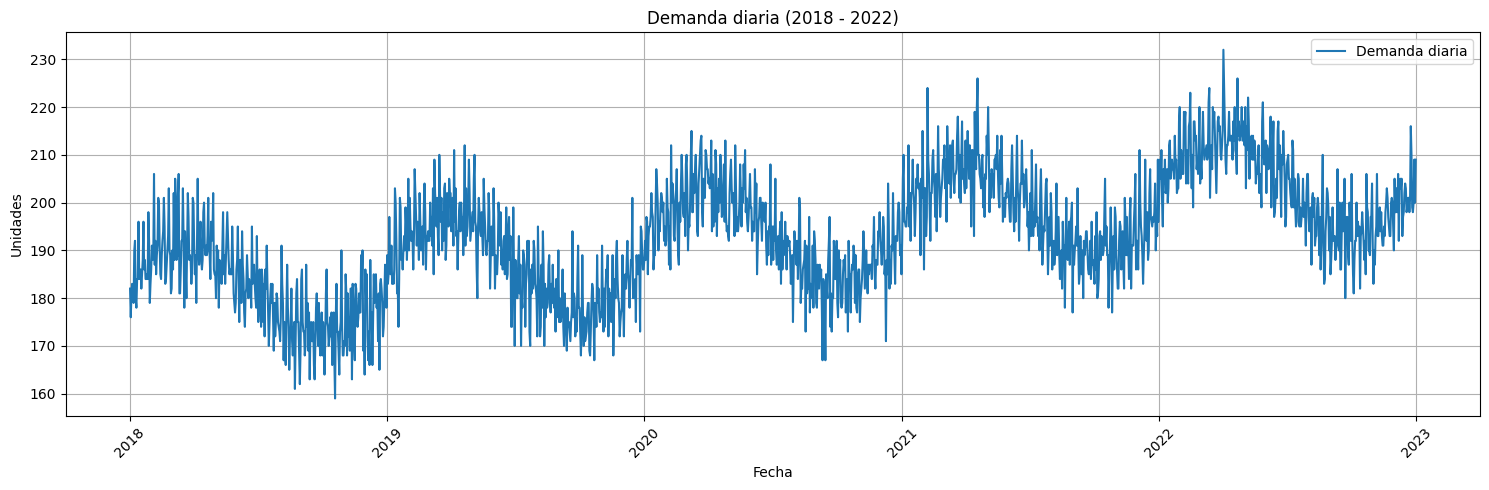

In [10]:
data['fecha'] = pd.to_datetime(data['fecha'])  # Asegura formato datetime
data = data.set_index('fecha')

plt.figure(figsize=(15, 5))
plt.plot(data['demanda'], label='Demanda diaria')
plt.title("Demanda diaria (2018 - 2022)")
plt.xlabel("Fecha")
plt.ylabel("Unidades")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# Establecer fecha como indice

data.set_index('fecha', inplace=True)

KeyError: "None of ['fecha'] are in the columns"

In [ ]:
# Usamos 4 años para entrenamiento y 1 año para test (2022)

train = data[:'2021']
test = data['2022':]

In [ ]:
train

In [ ]:
test

# Preprocesamiento

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar demanda
scaler = MinMaxScaler()
data['scaled'] = scaler.fit_transform(data[['demanda']])
data.head()

,producto,demanda,scaled
fecha,,,
2018-01-01,CERVEZA_LATA_350ML,182.0,0.315068
2018-01-02,CERVEZA_LATA_350ML,176.0,0.232877
2018-01-03,CERVEZA_LATA_350ML,181.0,0.301370
2018-01-04,CERVEZA_LATA_350ML,183.0,0.328767
2018-01-05,CERVEZA_LATA_350ML,181.0,0.301370


In [13]:
import numpy as np

# Crear ventanas deslizantes

# Días 1 al 7  → predice día 8  
# Días 2 al 8  → predice día 9  
# Días 3 al 9  → predice día 10  

n_lags = 14 # VENTANAS
series = data['scaled'].values
fechas = data.index

X, y, fechas_y = [], [], []

for i in range(n_lags, len(series)):
    X.append(series[i - n_lags:i])
    y.append(series[i])
    fechas_y.append(fechas[i])

# Corrección: convertir a np.array para poder comparar
fechas_y = np.array(fechas_y)

split_date = pd.to_datetime('2022-01-01')
train_mask = fechas_y < split_date
test_mask = fechas_y >= split_date

X = np.array(X)
y = np.array(y)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Simple RNN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# MODELO SIMPLE RNN
modelo_rnn = Sequential()
modelo_rnn.add(SimpleRNN(64, return_sequences=True, activation='tanh', input_shape=(X_train_rnn.shape[1], 1)))
modelo_rnn.add(SimpleRNN(32, activation='tanh'))
modelo_rnn.add(Dense(1))

modelo_rnn.compile(optimizer='adam', loss='mse')
modelo_rnn.fit(X_train_rnn, y_train, validation_split=0.2, epochs=50,
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=1)


Epoch 1/50


C:\Users\Diego\anaconda3\envs\gpu_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0582 - val_loss: 0.0088
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0117
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0115
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0068


In [15]:
# PREDICCIÓN
pred_rnn = modelo_rnn.predict(X_test_rnn).flatten()
pred_rnn_inv = scaler.inverse_transform(pred_rnn.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


In [16]:
# MÉTRICAS
mae_rnn = mean_absolute_error(y_test_inv, pred_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_inv, pred_rnn_inv)
print(f"Simple RNN =  MAE: {mae_rnn:.2f} | MSE: {mse_rnn:.2f} | RMSE: {rmse_rnn:.2f} | R²: {r2_rnn:.3f}")

Simple RNN =  MAE: 5.27 | MSE: 43.74 | RMSE: 6.61 | R²: 0.502


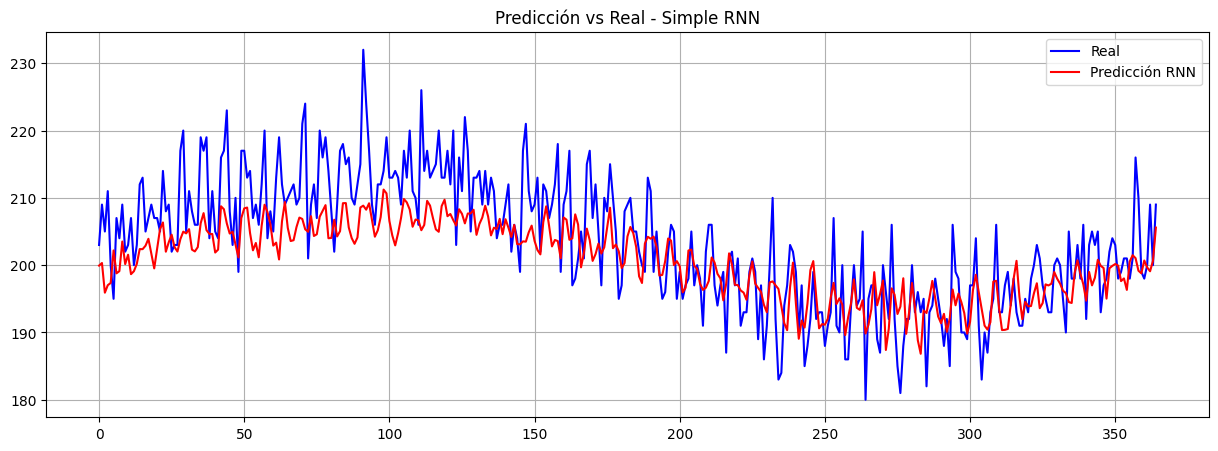

In [17]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_rnn_inv, label='Predicción RNN', linestyle='-', color='red')
plt.title("Predicción vs Real - Simple RNN")
plt.legend()
plt.grid(True)
plt.show()

# Red GRU (Unidades Recurrentes Cerradas)

In [18]:
from tensorflow.keras.layers import GRU, Dense, Input


# MODELO GRU
modelo_gru = Sequential()
modelo_gru.add(Input(shape=(X_train_rnn.shape[1], 1)))   # (timesteps, features)
modelo_gru.add(GRU(64, return_sequences=True, activation='tanh'))
modelo_gru.add(GRU(32, activation='tanh'))
modelo_gru.add(Dense(1))

modelo_gru.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_gru.fit(X_train_rnn, y_train,
               validation_split=0.2,
               epochs=50,
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
               verbose=1)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0428 - val_loss: 0.0082
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0078
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0078
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - val_loss: 0.0084
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0074
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_l

In [19]:
# PREDICCIÓN
pred_gru = modelo_gru.predict(X_test_rnn).flatten()
pred_gru_inv = scaler.inverse_transform(pred_gru.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


In [20]:
# MÉTRICAS
mae_gru = mean_absolute_error(y_test_inv, pred_gru_inv)
mse_gru = mean_squared_error(y_test_inv, pred_gru_inv)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_inv, pred_gru_inv)

print(f"GRU Profunda = MAE: {mae_gru:.2f} | MSE: {mse_gru:.2f} | RMSE: {rmse_gru:.2f} | R²: {r2_gru:.3f}")

GRU Profunda = MAE: 4.13 | MSE: 27.85 | RMSE: 5.28 | R²: 0.683


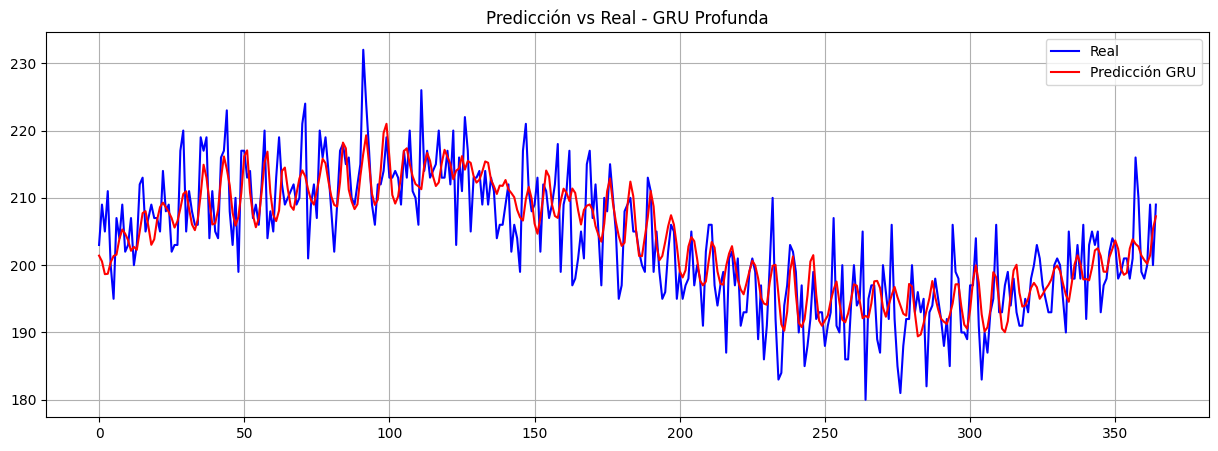

In [21]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_gru_inv, label='Predicción GRU', linestyle='-', color='red')
plt.title("Predicción vs Real - GRU Profunda")
plt.legend()
plt.grid(True)
plt.show()

# Red LSTM (Memoria larga a corto plazo)

In [22]:
from tensorflow.keras.layers import LSTM, Dense, Input

# MODELO LSTM
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train_rnn.shape[1], 1)))   # (timesteps, features)
modelo_lstm.add(LSTM(64, return_sequences=True, activation='tanh'))
modelo_lstm.add(LSTM(32, activation='tanh'))
modelo_lstm.add(Dense(1))

modelo_lstm.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_lstm.fit(X_train_rnn, y_train,
                validation_split=0.2,
                epochs=50,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=1)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0595 - val_loss: 0.0078
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - val_loss: 0.0076
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_l

In [23]:

# PREDICCIÓN
pred_lstm = modelo_lstm.predict(X_test_rnn).flatten()
pred_lstm_inv = scaler.inverse_transform(pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


In [24]:
# MÉTRICAS
mae_lstm = mean_absolute_error(y_test_inv, pred_lstm_inv)
mse_lstm = mean_squared_error(y_test_inv, pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_inv, pred_lstm_inv)

print(f"LSTM Profunda = MAE: {mae_lstm:.2f} | MSE: {mse_lstm:.2f} | RMSE: {rmse_lstm:.2f} | R²: {r2_lstm:.3f}")


LSTM Profunda = MAE: 4.59 | MSE: 34.21 | RMSE: 5.85 | R²: 0.611


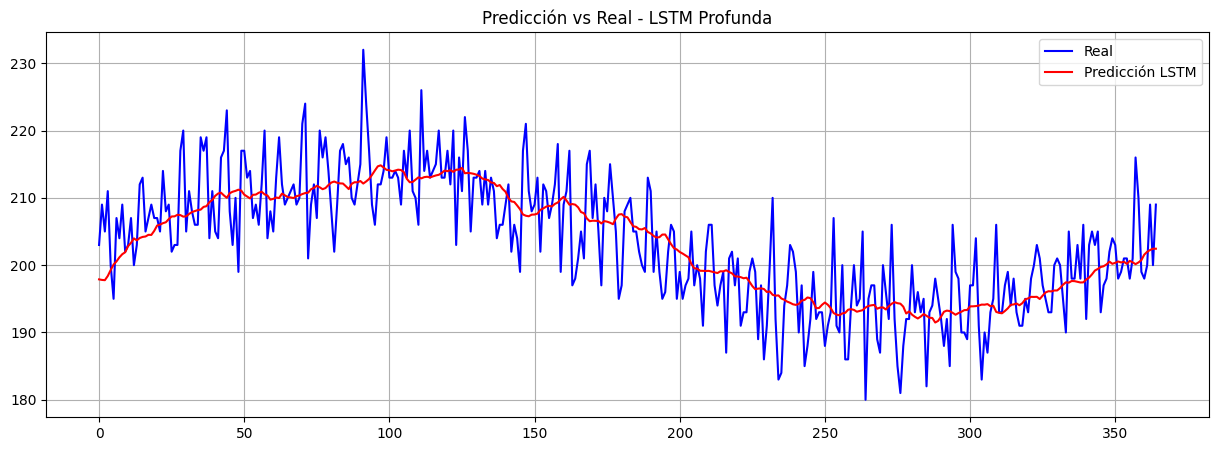

In [25]:

# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_lstm_inv, label='Predicción LSTM', linestyle='-', color='red')
plt.title("Predicción vs Real - LSTM Profunda")
plt.legend()
plt.grid(True)
plt.show()

# Creacion de Variables Exogenas

In [26]:
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import MinMaxScaler

# Cargar el dataset original
df = pd.read_csv('demanda.csv')
df.set_index('fecha', inplace=True)
df.index = pd.to_datetime(df.index)

# Feriados en Chile para todos los años del dataset
years = df.index.year.unique()
feriados_chile = holidays.country_holidays('CL', years=years)

# Variables exógenas
# Convertir fechas de feriados a datetime explícitamente
feriados_chile_dt = pd.to_datetime(list(feriados_chile.keys()))
df['es_feriado'] = df.index.isin(feriados_chile_dt).astype(int)
df['es_fin_semana'] = df.index.weekday.isin([5, 6]).astype(int)           # 1 si es sábado o domingo
df['dia_semana'] = df.index.weekday                                       # 0=Lunes, ..., 6=Domingo
df['mes'] = df.index.month                                                # 1 a 12
df['dia_del_anio'] = df.index.dayofyear                                   # 1 a 365
df['tendencia'] = np.arange(len(df)) / len(df)                            # tendencia lineal normalizada


# Escalar la demanda
scaler_y = MinMaxScaler()
df['scaled'] = scaler_y.fit_transform(df[['demanda']])

# Variables exógenas que se usarán
features_exogenas = ['es_feriado', 'es_fin_semana', 'dia_semana', 'mes', 'dia_del_anio', 'tendencia']

# Escalar variables exógenas
scaler_x = MinMaxScaler()
df[features_exogenas] = scaler_x.fit_transform(df[features_exogenas])

In [28]:
df.head()

,producto,demanda,es_feriado,es_fin_semana,dia_semana,mes,dia_del_anio,tendencia,scaled
fecha,,,,,,,,,
2018-01-01,CERVEZA_LATA_350ML,182.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.315068
2018-01-02,CERVEZA_LATA_350ML,176.0,0.0,0.0,0.166667,0.0,0.002740,0.000548,0.232877
2018-01-03,CERVEZA_LATA_350ML,181.0,0.0,0.0,0.333333,0.0,0.005479,0.001096,0.301370
2018-01-04,CERVEZA_LATA_350ML,183.0,0.0,0.0,0.500000,0.0,0.008219,0.001644,0.328767
2018-01-05,CERVEZA_LATA_350ML,181.0,0.0,0.0,0.666667,0.0,0.010959,0.002192,0.301370


In [29]:
df.shape

(1826, 9)

# Preprocesamiento

In [30]:
# Variables exógenas y target
features_exogenas = ['es_feriado', 'es_fin_semana', 'dia_semana', 'mes', 'dia_del_anio', 'tendencia']
target = 'scaled'

# Construcción de ventanas multivariadas
n_lags = 14 # (aqui estamos creando ventanas NO lags)
data_array = df[features_exogenas + [target]].values
fechas = df.index

X, y, fechas_y = [], [], []
for i in range(n_lags, len(data_array)):
    X.append(data_array[i - n_lags:i, :-1])  # ventanas de exógenas
    y.append(data_array[i, -1])              # target
    fechas_y.append(fechas[i])

X = np.array(X)
y = np.array(y)
fechas_y = np.array(fechas_y)

# Separar por fecha como lo hacías tú
split_date = pd.to_datetime('2022-01-01')
train_mask = fechas_y < split_date
test_mask = fechas_y >= split_date

X_train_mv = X[train_mask]
X_test_mv = X[test_mask]
y_train_mv = y[train_mask]
y_test_mv = y[test_mask]


# Simple RNN

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# MODELO RNN
modelo_rnn = Sequential()
modelo_rnn.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_rnn.add(SimpleRNN(64, return_sequences=True, activation='tanh'))
modelo_rnn.add(SimpleRNN(32, activation='tanh'))
modelo_rnn.add(Dense(1))

modelo_rnn.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_rnn.fit(X_train_mv, y_train_mv,
               validation_split=0.2,
               epochs=50,
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
               verbose=1)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0461 - val_loss: 0.0149
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0084
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0071
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0082
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0116
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_lo

In [32]:
# PREDICCIÓN
pred_rnn = modelo_rnn.predict(X_test_mv).flatten()
pred_rnn_inv = scaler_y.inverse_transform(pred_rnn.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


In [33]:
# MÉTRICAS
mae_rnn = mean_absolute_error(y_test_inv, pred_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_inv, pred_rnn_inv)

print(f"Simple RNN = MAE: {mae_rnn:.2f} | MSE: {mse_rnn:.2f} | RMSE: {rmse_rnn:.2f} | R²: {r2_rnn:.3f}")

Simple RNN = MAE: 4.84 | MSE: 37.50 | RMSE: 6.12 | R²: 0.573


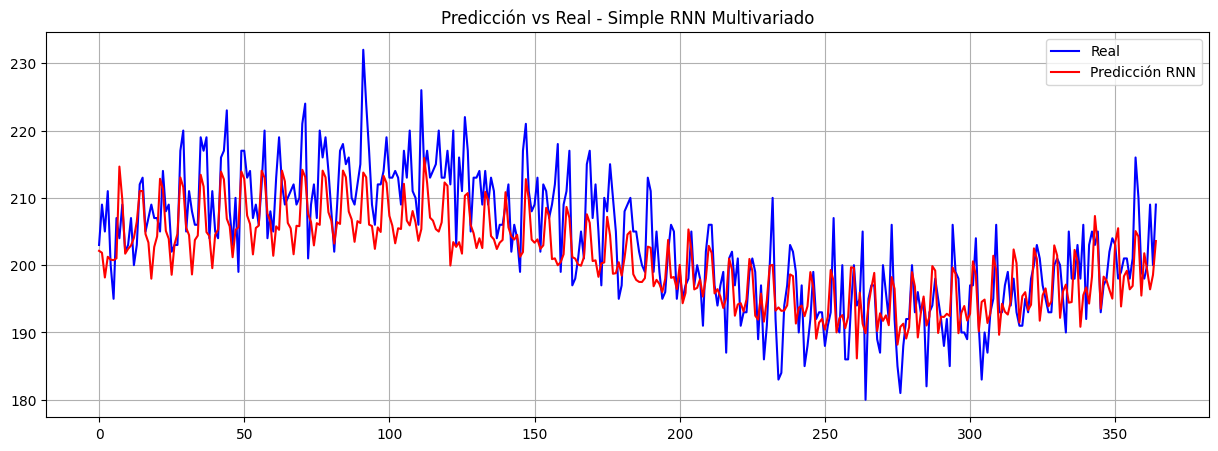

In [34]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_rnn_inv, label='Predicción RNN', linestyle='-', color='red')
plt.title("Predicción vs Real - Simple RNN Multivariado")
plt.legend()
plt.grid(True)
plt.show()

# Red GRU

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

# Crear modelo GRU multivariado
modelo_gru = Sequential()
modelo_gru.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_gru.add(GRU(64, return_sequences=True, activation='tanh'))
modelo_gru.add(GRU(32, activation='tanh'))
modelo_gru.add(Dense(1))

modelo_gru.compile(optimizer='adam', loss='mse')


# Entrenamiento con early stopping
modelo_gru.fit(
    X_train_mv, y_train_mv,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0382 - val_loss: 0.0103
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - val_loss: 0.0099
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - val_loss: 0.0095
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0091
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0103
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_l

In [36]:
# Predicción del conjunto de test
pred_gru = modelo_gru.predict(X_test_mv).flatten()

# Inversión del escalado para comparar en unidades reales
pred_gru_inv = scaler_y.inverse_transform(pred_gru.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_gru = mean_absolute_error(y_test_inv, pred_gru_inv)
mse_gru = mean_squared_error(y_test_inv, pred_gru_inv)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_inv, pred_gru_inv)

print(f"GRU Multivariado")
print(f"MAE: {mae_gru:.2f}")
print(f"MSE: {mse_gru:.2f}")
print(f"RMSE: {rmse_gru:.2f}")
print(f"R²: {r2_gru:.3f}")


GRU Multivariado
MAE: 5.26
MSE: 42.88
RMSE: 6.55
R²: 0.512


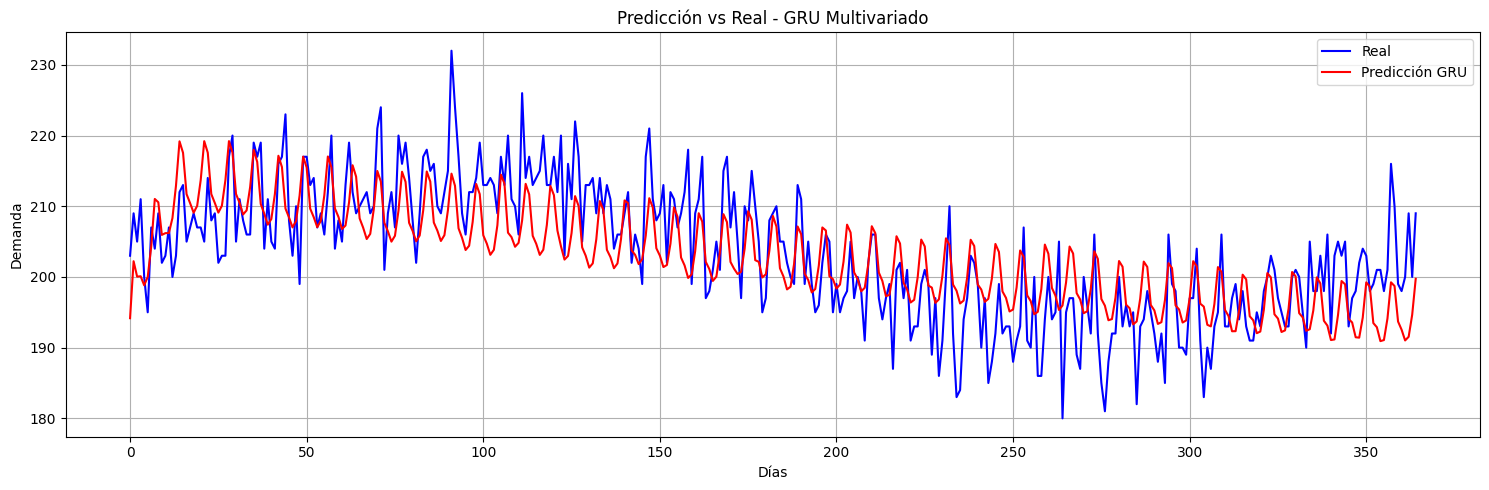

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_gru_inv, label='Predicción GRU', linestyle='-', color='red')
plt.title("Predicción vs Real - GRU Multivariado")
plt.xlabel("Días")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Crear modelo LSTM multivariado
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_lstm.add(LSTM(64, return_sequences=True, activation='tanh'))
modelo_lstm.add(LSTM(32, activation='tanh'))
modelo_lstm.add(Dense(1))

modelo_lstm.compile(optimizer='adam', loss='mse')

from tensorflow.keras.callbacks import EarlyStopping

# Entrenamiento con early stopping
modelo_lstm.fit(
    X_train_mv, y_train_mv,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0414 - val_loss: 0.0105
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - val_loss: 0.0094
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_l

In [40]:
# Predicción del conjunto de test
pred_lstm = modelo_lstm.predict(X_test_mv).flatten()

# Inversión del escalado para comparar en unidades reales
pred_lstm_inv = scaler_y.inverse_transform(pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_lstm = mean_absolute_error(y_test_inv, pred_lstm_inv)
mse_lstm = mean_squared_error(y_test_inv, pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_inv, pred_lstm_inv)

print(f"LSTM Multivariado")
print(f"MAE: {mae_lstm:.2f}")
print(f"MSE: {mse_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.3f}")


LSTM Multivariado
MAE: 3.97
MSE: 24.66
RMSE: 4.97
R²: 0.719


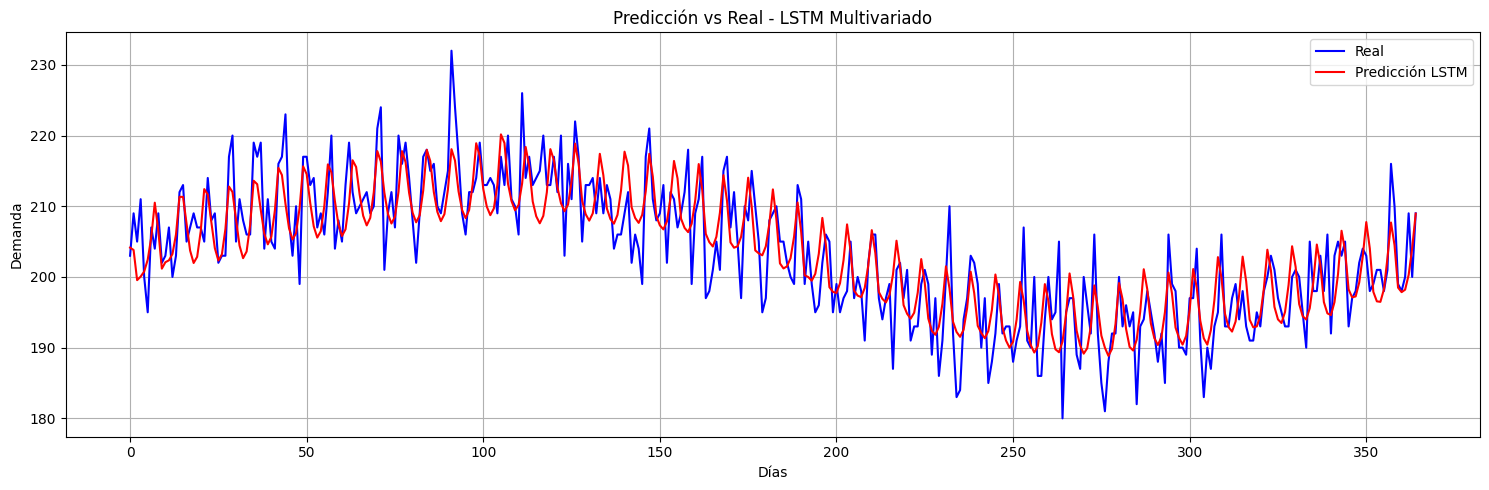

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_lstm_inv, label='Predicción LSTM', linestyle='-', color='red')
plt.title("Predicción vs Real - LSTM Multivariado")
plt.xlabel("Días")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Preprocesamiento II o Agregar mas variables exogenas

In [43]:
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import MinMaxScaler

# Cargar el dataset
df = pd.read_csv('demanda.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)

# Feriados en Chile
years = df.index.year.unique()
feriados_chile = holidays.country_holidays('CL', years=years)
feriados_chile_dt = pd.to_datetime(list(feriados_chile.keys()))
df['es_feriado'] = df.index.isin(feriados_chile_dt).astype(int)
df['es_fin_semana'] = df.index.weekday.isin([5, 6]).astype(int)
df['dia_semana'] = df.index.weekday
df['mes'] = df.index.month
df['dia_del_anio'] = df.index.dayofyear
df['tendencia'] = np.arange(len(df)) / len(df)  # tendencia lineal normalizada

# ===== Nuevas variables exógenas =====
# Lags de demanda
df['lag_1'] = df['demanda'].shift(1)
df['lag_7'] = df['demanda'].shift(7)
df['lag_14'] = df['demanda'].shift(14)

# Promedios móviles
df['media_7'] = df['demanda'].rolling(window=7).mean()
df['media_14'] = df['demanda'].rolling(window=14).mean()
df['media_30'] = df['demanda'].rolling(window=30).mean()

# Desviación estándar móvil
df['std_7'] = df['demanda'].rolling(window=7).std()
df['std_30'] = df['demanda'].rolling(window=30).std()

# Ventas acumuladas normalizadas
df['acumulado'] = df['demanda'].cumsum()
df['acumulado'] = df['acumulado'] / df['acumulado'].max()

# Eliminar primeras filas con NaN por lags o rolling
df.dropna(inplace=True)

# Escalar variable objetivo
scaler_y = MinMaxScaler()
df['scaled'] = scaler_y.fit_transform(df[['demanda']])

# Variables exógenas a usar
features_exogenas = [
    'es_feriado', 'es_fin_semana', 'dia_semana', 'mes', 'dia_del_anio', 'tendencia',
    'lag_1', 'lag_7', 'lag_14',
    'media_7', 'media_14', 'media_30',
    'std_7', 'std_30', 'acumulado'
]

# Escalado de features exógenas
scaler_x = MinMaxScaler()
df[features_exogenas] = scaler_x.fit_transform(df[features_exogenas])

# Mostrar un resumen
print(df[features_exogenas + ['scaled']].head())


            es_feriado  es_fin_semana  dia_semana       mes  dia_del_anio  \
fecha                                                                       
2018-01-30         0.0            0.0    0.166667  0.000000      0.079452   
2018-01-31         0.0            0.0    0.333333  0.000000      0.082192   
2018-02-01         0.0            0.0    0.500000  0.090909      0.084932   
2018-02-02         0.0            0.0    0.666667  0.090909      0.087671   
2018-02-03         0.0            1.0    0.833333  0.090909      0.090411   

            tendencia     lag_1     lag_7    lag_14   media_7  media_14  \
fecha                                                                     
2018-01-30   0.000000  0.273973  0.342466  0.369863  0.349544  0.348039   
2018-01-31   0.000557  0.328767  0.342466  0.315068  0.355623  0.354575   
2018-02-01   0.001114  0.369863  0.356164  0.356164  0.373860  0.364379   
2018-02-02   0.001670  0.438356  0.342466  0.397260  0.386018  0.364379   
2018-02-03

In [44]:
df.head()

,producto,demanda,es_feriado,es_fin_semana,dia_semana,mes,dia_del_anio,tendencia,lag_1,lag_7,lag_14,media_7,media_14,media_30,std_7,std_30,acumulado,scaled
fecha,,,,,,,,,,,,,,,,,,
2018-01-30,CERVEZA_LATA_350ML,183.0,0.0,0.0,0.166667,0.000000,0.079452,0.000000,0.273973,0.342466,0.369863,0.349544,0.348039,0.302508,0.468063,0.294790,0.000000,0.328767
2018-01-31,CERVEZA_LATA_350ML,186.0,0.0,0.0,0.333333,0.000000,0.082192,0.000557,0.328767,0.342466,0.315068,0.355623,0.354575,0.305643,0.460542,0.287072,0.000537,0.369863
2018-02-01,CERVEZA_LATA_350ML,191.0,0.0,0.0,0.500000,0.090909,0.084932,0.001114,0.369863,0.356164,0.356164,0.373860,0.364379,0.317398,0.472799,0.238394,0.001088,0.438356
2018-02-02,CERVEZA_LATA_350ML,188.0,0.0,0.0,0.666667,0.090909,0.087671,0.001670,0.438356,0.342466,0.397260,0.386018,0.364379,0.322884,0.455010,0.222162,0.001630,0.397260
2018-02-03,CERVEZA_LATA_350ML,189.0,0.0,1.0,0.833333,0.090909,0.090411,0.002227,0.397260,0.534247,0.506849,0.358663,0.352941,0.327586,0.303618,0.220551,0.002176,0.410959


In [46]:
df.shape

(1797, 18)

In [47]:
# Construcción de ventanas multivariadas
n_lags = 14 # (aqui estamos creando ventanas NO lags)
data_array = df[features_exogenas + [target]].values
fechas = df.index

X, y, fechas_y = [], [], []
for i in range(n_lags, len(data_array)):
    X.append(data_array[i - n_lags:i, :-1])  # ventanas de exógenas
    y.append(data_array[i, -1])              # target
    fechas_y.append(fechas[i])

X = np.array(X)
y = np.array(y)
fechas_y = np.array(fechas_y)

# Separar por fecha como lo hacías tú
split_date = pd.to_datetime('2022-01-01')
train_mask = fechas_y < split_date
test_mask = fechas_y >= split_date

X_train_mv = X[train_mask]
X_test_mv = X[test_mask]
y_train_mv = y[train_mask]
y_test_mv = y[test_mask]


# Simple RNN con mas variables exogenas

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# MODELO RNN
modelo_rnn = Sequential()
modelo_rnn.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_rnn.add(SimpleRNN(64, return_sequences=True, activation='tanh'))
modelo_rnn.add(SimpleRNN(32, activation='tanh'))
modelo_rnn.add(Dense(1))

modelo_rnn.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_rnn.fit(X_train_mv, y_train_mv,
               validation_split=0.2,
               epochs=50,
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
               verbose=1)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0937 - val_loss: 0.0113
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - val_loss: 0.0126
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0078
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_l

In [49]:
# PREDICCIÓN
pred_rnn = modelo_rnn.predict(X_test_mv).flatten()
pred_rnn_inv = scaler_y.inverse_transform(pred_rnn.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


In [50]:


# MÉTRICAS
mae_rnn = mean_absolute_error(y_test_inv, pred_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_inv, pred_rnn_inv)

print(f"Simple RNN = MAE: {mae_rnn:.2f} | MSE: {mse_rnn:.2f} | RMSE: {rmse_rnn:.2f} | R²: {r2_rnn:.3f}")

Simple RNN = MAE: 4.03 | MSE: 25.75 | RMSE: 5.07 | R²: 0.707


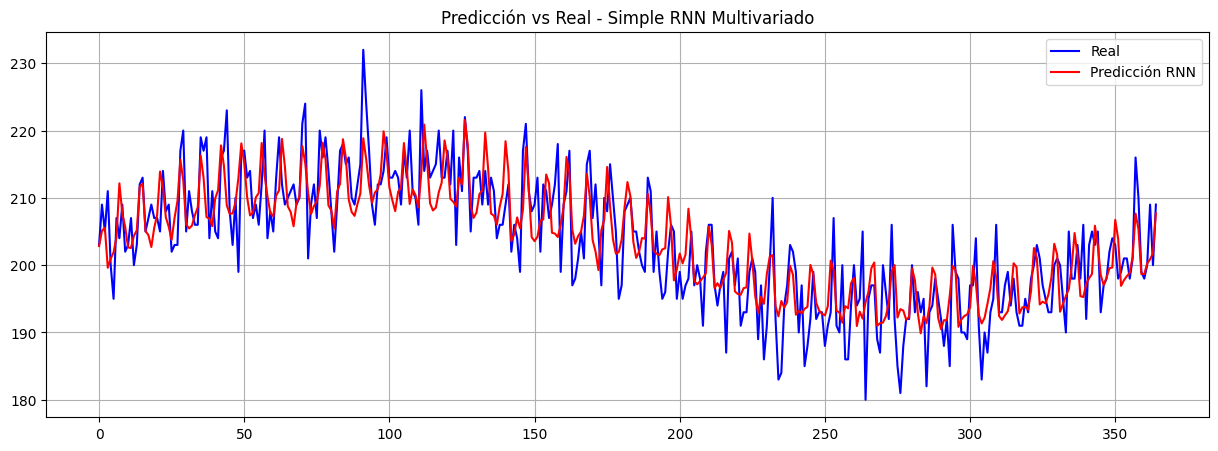

In [51]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_rnn_inv, label='Predicción RNN', linestyle='-', color='red')
plt.title("Predicción vs Real - Simple RNN Multivariado")
plt.legend()
plt.grid(True)
plt.show()

# GRU

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

# Crear modelo GRU multivariado
modelo_gru = Sequential()
modelo_gru.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_gru.add(GRU(64, return_sequences=True, activation='tanh'))
modelo_gru.add(GRU(32, activation='tanh'))
modelo_gru.add(Dense(1))

modelo_gru.compile(optimizer='adam', loss='mse')


# Entrenamiento con early stopping
modelo_gru.fit(
    X_train_mv, y_train_mv,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1426 - val_loss: 0.0101
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0064


In [53]:
# Predicción del conjunto de test
pred_gru = modelo_gru.predict(X_test_mv).flatten()

# Inversión del escalado para comparar en unidades reales
pred_gru_inv = scaler_y.inverse_transform(pred_gru.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_gru = mean_absolute_error(y_test_inv, pred_gru_inv)
mse_gru = mean_squared_error(y_test_inv, pred_gru_inv)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_inv, pred_gru_inv)

print(f"GRU Multivariado")
print(f"MAE: {mae_gru:.2f}")
print(f"MSE: {mse_gru:.2f}")
print(f"RMSE: {rmse_gru:.2f}")
print(f"R²: {r2_gru:.3f}")


GRU Multivariado
MAE: 4.32
MSE: 29.86
RMSE: 5.46
R²: 0.660


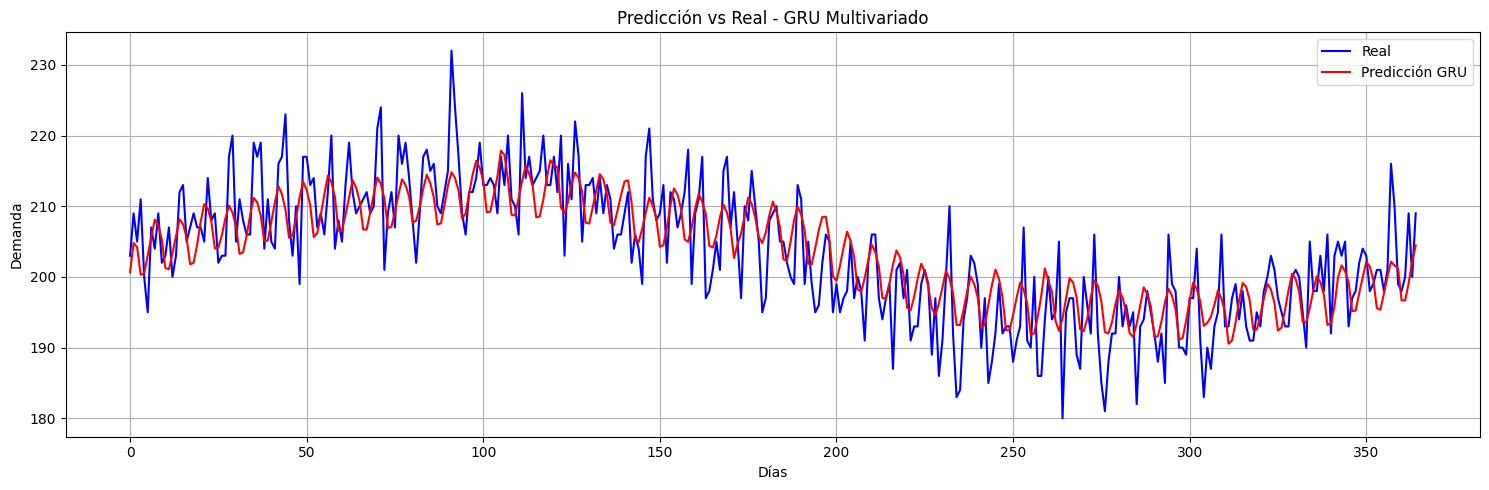

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_gru_inv, label='Predicción GRU', linestyle='-', color='red')
plt.title("Predicción vs Real - GRU Multivariado")
plt.xlabel("Días")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Crear modelo LSTM multivariado
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_lstm.add(LSTM(64, return_sequences=True, activation='tanh'))
modelo_lstm.add(LSTM(32, activation='tanh'))
modelo_lstm.add(Dense(1))

modelo_lstm.compile(optimizer='adam', loss='mse')

from tensorflow.keras.callbacks import EarlyStopping

# Entrenamiento con early stopping
modelo_lstm.fit(
    X_train_mv, y_train_mv,
    validation_split=0.2,
    epochs=100,
    callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0328 - val_loss: 0.0086
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0075
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0066
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0066
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - val_l

In [57]:
# Predicción del conjunto de test
pred_lstm = modelo_lstm.predict(X_test_mv).flatten()

# Inversión del escalado para comparar en unidades reales
pred_lstm_inv = scaler_y.inverse_transform(pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_lstm = mean_absolute_error(y_test_inv, pred_lstm_inv)
mse_lstm = mean_squared_error(y_test_inv, pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_inv, pred_lstm_inv)

print(f"LSTM Multivariado")
print(f"MAE: {mae_lstm:.2f}")
print(f"MSE: {mse_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.3f}")

LSTM Multivariado
MAE: 4.00
MSE: 25.88
RMSE: 5.09
R²: 0.705


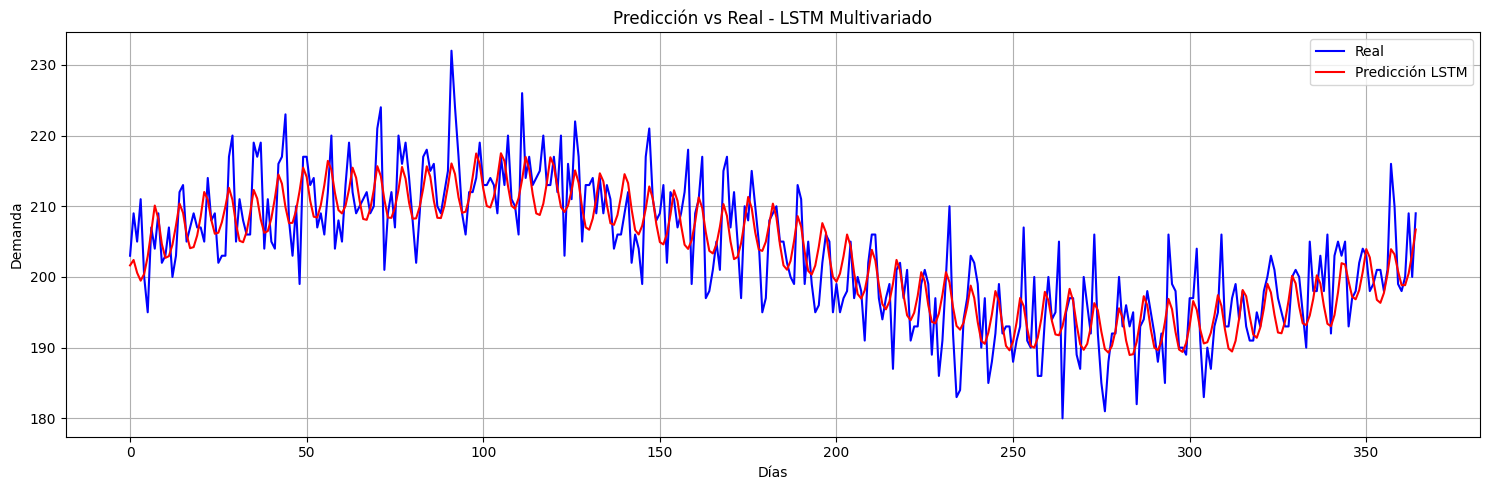

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_lstm_inv, label='Predicción LSTM', linestyle='-', color='red')
plt.title("Predicción vs Real - LSTM Multivariado")
plt.xlabel("Días")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Preprocesamiento III agregar aun mas variables exogenas

In [60]:
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import MinMaxScaler

# Cargar el dataset
df = pd.read_csv('demanda.csv')
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)

# Feriados en Chile
years = df.index.year.unique()
feriados_chile = holidays.country_holidays('CL', years=years)
feriados_chile_dt = pd.to_datetime(list(feriados_chile.keys()))
df['es_feriado'] = df.index.isin(feriados_chile_dt).astype(int)
df['es_fin_semana'] = df.index.weekday.isin([5, 6]).astype(int)
df['dia_semana'] = df.index.weekday
df['mes'] = df.index.month
df['dia_del_anio'] = df.index.dayofyear
df['tendencia'] = np.arange(len(df)) / len(df)  # tendencia lineal normalizada

# ==== Nuevas variables temporales cíclicas ====
# Día del año en forma de seno y coseno (estacionalidad anual)
df['sen_dia_ano'] = np.sin(2 * np.pi * df['dia_del_anio'] / 365)
df['cos_dia_ano'] = np.cos(2 * np.pi * df['dia_del_anio'] / 365)

# Día de la semana en forma de seno y coseno (estacionalidad semanal)
df['sen_dia_semana'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
df['cos_dia_semana'] = np.cos(2 * np.pi * df['dia_semana'] / 7)

# Mes en forma de seno y coseno (estacionalidad mensual)
df['sen_mes'] = np.sin(2 * np.pi * df['mes'] / 12)
df['cos_mes'] = np.cos(2 * np.pi * df['mes'] / 12)

# ==== Nuevas tendencias ====
# Tendencia cuadrática y logarítmica (pueden mejorar patrones de largo plazo)
df['tendencia2'] = df['tendencia'] ** 2
df['tendencia_log'] = np.log1p(df['tendencia'] * (len(df)))  # log(1 + t)

# ==== Lags y rolling ====
df['lag_1'] = df['demanda'].shift(1)
df['lag_7'] = df['demanda'].shift(7)
df['lag_14'] = df['demanda'].shift(14)
df['media_7'] = df['demanda'].rolling(window=7).mean()
df['media_14'] = df['demanda'].rolling(window=14).mean()
df['media_30'] = df['demanda'].rolling(window=30).mean()
df['std_7'] = df['demanda'].rolling(window=7).std()
df['std_30'] = df['demanda'].rolling(window=30).std()
df['acumulado'] = df['demanda'].cumsum()
df['acumulado'] = df['acumulado'] / df['acumulado'].max()

# Eliminar primeras filas con NaN
df.dropna(inplace=True)

# Escalar variable objetivo
scaler_y = MinMaxScaler()
df['scaled'] = scaler_y.fit_transform(df[['demanda']])

# ==== Variables exógenas finales ====
features_exogenas = [
    'es_feriado', 'es_fin_semana',
    'dia_semana', 'mes', 'dia_del_anio',
    'sen_dia_ano', 'cos_dia_ano',
    'sen_dia_semana', 'cos_dia_semana',
    'sen_mes', 'cos_mes',
    'tendencia', 'tendencia2', 'tendencia_log',
    'lag_1', 'lag_7', 'lag_14',
    'media_7', 'media_14', 'media_30',
    'std_7', 'std_30', 'acumulado'
]

# Escalar features exógenas
scaler_x = MinMaxScaler()
df[features_exogenas] = scaler_x.fit_transform(df[features_exogenas])

# Vista final
print(df[features_exogenas + ['scaled']].tail())


            es_feriado  es_fin_semana  dia_semana  mes  dia_del_anio  \
fecha                                                                  
2022-12-27         0.0            0.0    0.166667  1.0      0.986301   
2022-12-28         0.0            0.0    0.333333  1.0      0.989041   
2022-12-29         0.0            0.0    0.500000  1.0      0.991781   
2022-12-30         0.0            0.0    0.666667  1.0      0.994521   
2022-12-31         0.0            1.0    0.833333  1.0      0.997260   

            sen_dia_ano  cos_dia_ano  sen_dia_semana  cos_dia_semana  sen_mes  \
fecha                                                                           
2022-12-27     0.465598     0.998815        0.900969    8.019377e-01      0.5   
2022-12-28     0.474190     0.999333        1.000000    3.568959e-01      0.5   
2022-12-29     0.482789     0.999704        0.722521    5.551115e-17      0.5   
2022-12-30     0.491393     0.999926        0.277479    0.000000e+00      0.5   
2022-12-3

In [61]:
df.head()

,producto,demanda,es_feriado,es_fin_semana,dia_semana,mes,dia_del_anio,tendencia,sen_dia_ano,cos_dia_ano,...,lag_1,lag_7,lag_14,media_7,media_14,media_30,std_7,std_30,acumulado,scaled
fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-30,CERVEZA_LATA_350ML,183.0,0.0,0.0,0.166667,0.000000,0.079452,0.000000,0.746890,0.934793,...,0.273973,0.342466,0.369863,0.349544,0.348039,0.302508,0.468063,0.294790,0.000000,0.328767
2018-01-31,CERVEZA_LATA_350ML,186.0,0.0,0.0,0.333333,0.000000,0.082192,0.000557,0.754338,0.930479,...,0.328767,0.342466,0.315068,0.355623,0.354575,0.305643,0.460542,0.287072,0.000537,0.369863
2018-02-01,CERVEZA_LATA_350ML,191.0,0.0,0.0,0.500000,0.090909,0.084932,0.001114,0.761710,0.926037,...,0.369863,0.356164,0.356164,0.373860,0.364379,0.317398,0.472799,0.238394,0.001088,0.438356
2018-02-02,CERVEZA_LATA_350ML,188.0,0.0,0.0,0.666667,0.090909,0.087671,0.001670,0.769005,0.921469,...,0.438356,0.342466,0.397260,0.386018,0.364379,0.322884,0.455010,0.222162,0.001630,0.397260
2018-02-03,CERVEZA_LATA_350ML,189.0,0.0,1.0,0.833333,0.090909,0.090411,0.002227,0.776220,0.916776,...,0.397260,0.534247,0.506849,0.358663,0.352941,0.327586,0.303618,0.220551,0.002176,0.410959


In [62]:
# Construcción de ventanas multivariadas
n_lags = 14 # (aqui estamos creando ventanas NO lags)
data_array = df[features_exogenas + [target]].values
fechas = df.index

X, y, fechas_y = [], [], []
for i in range(n_lags, len(data_array)):
    X.append(data_array[i - n_lags:i, :-1])  # ventanas de exógenas
    y.append(data_array[i, -1])              # target
    fechas_y.append(fechas[i])

X = np.array(X)
y = np.array(y)
fechas_y = np.array(fechas_y)

# Separar por fecha como lo hacías tú
split_date = pd.to_datetime('2022-01-01')
train_mask = fechas_y < split_date
test_mask = fechas_y >= split_date

X_train_mv = X[train_mask]
X_test_mv = X[test_mask]
y_train_mv = y[train_mask]
y_test_mv = y[test_mask]

# Simple RNN

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# MODELO RNN
modelo_rnn = Sequential()
modelo_rnn.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_rnn.add(SimpleRNN(64, return_sequences=True, activation='tanh'))
modelo_rnn.add(SimpleRNN(32, activation='tanh'))
modelo_rnn.add(Dense(1))

modelo_rnn.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_rnn.fit(X_train_mv, y_train_mv,
               validation_split=0.2,
               epochs=100,
               callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
               verbose=1)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4212 - val_loss: 0.0462
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.0216
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - val_loss: 0.0207
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0167
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0166
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0113
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0140
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0109
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0133
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0128
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [64]:
# PREDICCIÓN
pred_rnn = modelo_rnn.predict(X_test_mv).flatten()
pred_rnn_inv = scaler_y.inverse_transform(pred_rnn.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


In [65]:

# MÉTRICAS
mae_rnn = mean_absolute_error(y_test_inv, pred_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_inv, pred_rnn_inv)

print(f"Simple RNN = MAE: {mae_rnn:.2f} | MSE: {mse_rnn:.2f} | RMSE: {rmse_rnn:.2f} | R²: {r2_rnn:.3f}")

Simple RNN = MAE: 4.61 | MSE: 33.55 | RMSE: 5.79 | R²: 0.618


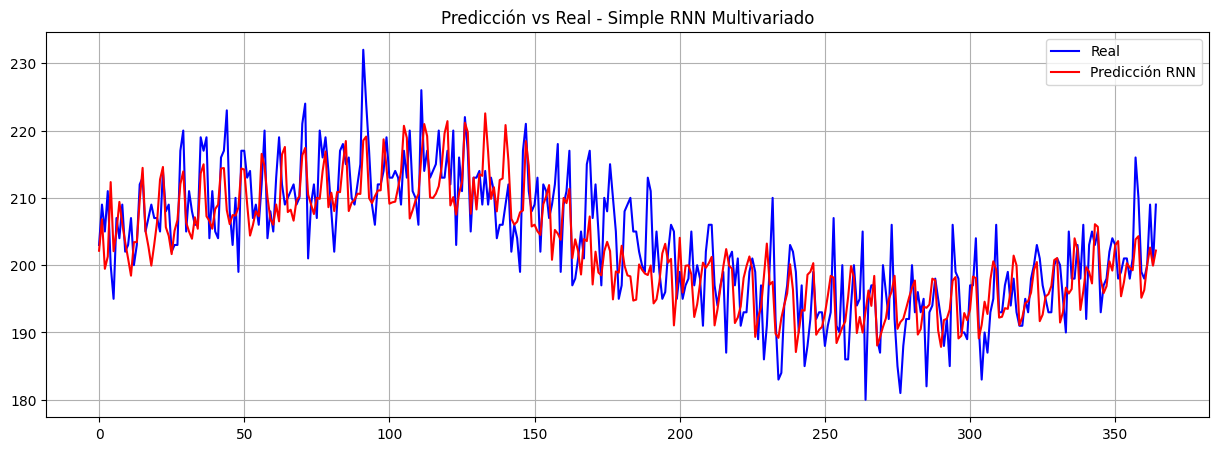

In [66]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_rnn_inv, label='Predicción RNN', linestyle='-', color='red')
plt.title("Predicción vs Real - Simple RNN Multivariado")
plt.legend()
plt.grid(True)
plt.show()

# GRU

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

# Crear modelo GRU multivariado
modelo_gru = Sequential()
modelo_gru.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_gru.add(GRU(64, return_sequences=True, activation='tanh'))
modelo_gru.add(GRU(32, activation='tanh'))
modelo_gru.add(Dense(1))

modelo_gru.compile(optimizer='adam', loss='mse')


# Entrenamiento con early stopping
modelo_gru.fit(
    X_train_mv, y_train_mv,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=15, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1184 - val_loss: 0.0077
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_l

In [68]:
# Predicción del conjunto de test
pred_gru = modelo_gru.predict(X_test_mv).flatten()

# Inversión del escalado para comparar en unidades reales
pred_gru_inv = scaler_y.inverse_transform(pred_gru.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_gru = mean_absolute_error(y_test_inv, pred_gru_inv)
mse_gru = mean_squared_error(y_test_inv, pred_gru_inv)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_inv, pred_gru_inv)

print(f"GRU Multivariado")
print(f"MAE: {mae_gru:.2f}")
print(f"MSE: {mse_gru:.2f}")
print(f"RMSE: {rmse_gru:.2f}")
print(f"R²: {r2_gru:.3f}")


GRU Multivariado
MAE: 3.95
MSE: 24.78
RMSE: 4.98
R²: 0.718


In [ ]:
# HACER EL GRAFICO DE PREDICCIONES



# LSTM